In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

In [2]:
columns = ["sentiment", "ids", "date", "flag", "user", "text"]
encoding = "ISO-8859-1"
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding=encoding, names = columns)

In [3]:
data.head(10)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment    1600000 non-null int64
ids          1600000 non-null int64
date         1600000 non-null object
flag         1600000 non-null object
user         1600000 non-null object
text         1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
data['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

As you see, we are dealing with a **balanced** machine learning problem and we don't need to balance the data.

In [6]:
#we do not need ids, date and flag 
#We want to classify the sentiment only with the text and the tweet
data = data[['sentiment','text']]
#In most of the machine learning problems that we have 2 classes, we use 0 and 1 as the labels
#I replace 4 with 1
data['sentiment'] = data['sentiment'].replace(4,1)
tweets = list(data["text"])
labels = list(data["sentiment"])

### Preprocessing

In [7]:
#we should remove the stop words as they 
#appear both in positive and negative tweets and they do not have
#any impact in the sentiment of the tweet
#Here are the list of stop words
import nltk
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
#One of the most important things in tweets are the emojis and they have a crucial role
#in setting the sentiment if the tweets
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip'}

In [9]:
#Another important issue in natural language processing is word lemmatize
#For example both better and good have same meaning and It's better to consider them as
#one words. Or for example books and book are same. 
lemmatizer = WordNetLemmatizer() 
print("good :", lemmatizer.lemmatize("good", pos ="a")) 
print("better :", lemmatizer.lemmatize("better", pos ="a")) 
print("best :", lemmatizer.lemmatize("best", pos ="a"))
print("bad :", lemmatizer.lemmatize("bad", pos ="a")) 
print("worse :", lemmatizer.lemmatize("worse", pos ="a")) 
print("worst :", lemmatizer.lemmatize("worst", pos ="a"))
print("books :", lemmatizer.lemmatize("books")) 
print("book :", lemmatizer.lemmatize("book")) 

good : good
better : good
best : best
bad : bad
worse : bad
worst : bad
books : book
book : book


In [10]:
tweets[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [11]:
#transform all the data to lower case
for i in range(len(tweets)):
    tweets[i] = tweets[i].lower()

In [12]:
tweets[0]

"@switchfoot http://twitpic.com/2y1zl - awww, that's a bummer.  you shoulda got david carr of third day to do it. ;d"

In [13]:
#replacing the emojis
for i in range(len(tweets)):
    for emoji in emojis:
        tweets[i] = tweets[i].replace(emoji, " " + emojis[emoji]+ " ")

In [14]:
tweets[0]

"@switchfoot http://twitpic.com/2y1zl - awww, that's a bummer.  you shoulda got david carr of third day to do it.  wink "

In [15]:
#The websites and urls in the tweets do not have any meaning. I decide to remove them from tweets
#The usernames are same as the websited and I remove them too
for i in range(len(tweets)):
    tweets[i] = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", " ", tweets[i])
    tweets[i] = re.sub("@[^\s]+", " ", tweets[i])
    tweets[i] = re.sub("[^a-zA-Z0-9]", " ", tweets[i])

In [47]:
tweets[0]

'      awww  that s a bummer   you shoulda got david carr of third day to do it  wink'

In [16]:
tweets[0].split()

['awww',
 'that',
 's',
 'a',
 'bummer',
 'you',
 'shoulda',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it',
 'wink']

In [17]:
from nltk.tokenize import word_tokenize
word_tokenize(tweets[0])

['awww',
 'that',
 's',
 'a',
 'bummer',
 'you',
 'shoulda',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it',
 'wink']

In [18]:
#I remove the words that have length if 1 and they are in stop words
clean_data = []
for i in range(len(tweets)):
    clean = ""
    temp = tweets[i].split()
    for t in temp:
        if(len(t)>1 and not t in stopWords):
            clean += lemmatizer.lemmatize(t) + " "
    clean_data.append(clean)   

In [19]:
clean_data[0]

'awww bummer shoulda got david carr third day wink '

In [63]:
negative_tweets = clean_data[:800000]

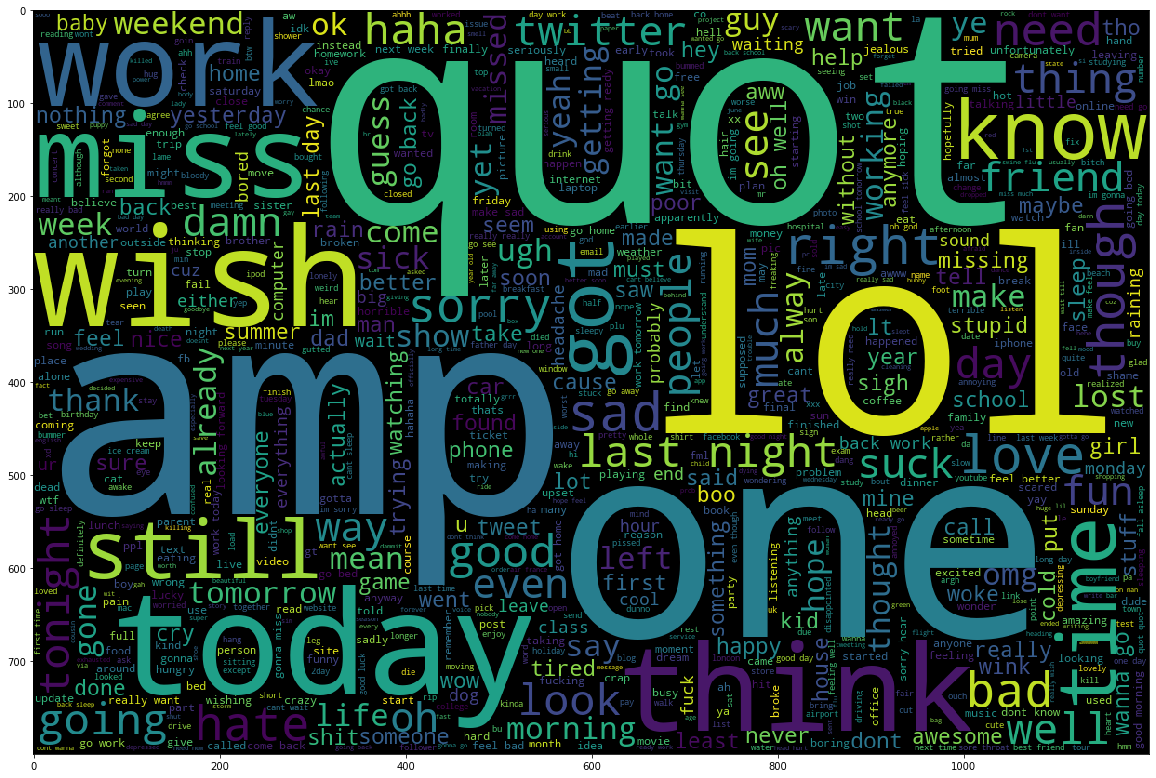

In [64]:
plt.figure(figsize = (20,20))
wordCloud = WordCloud(max_words = 800 , width = 1200 , height = 800).generate(" ".join(negative_tweets))
plt.imshow(wordCloud)

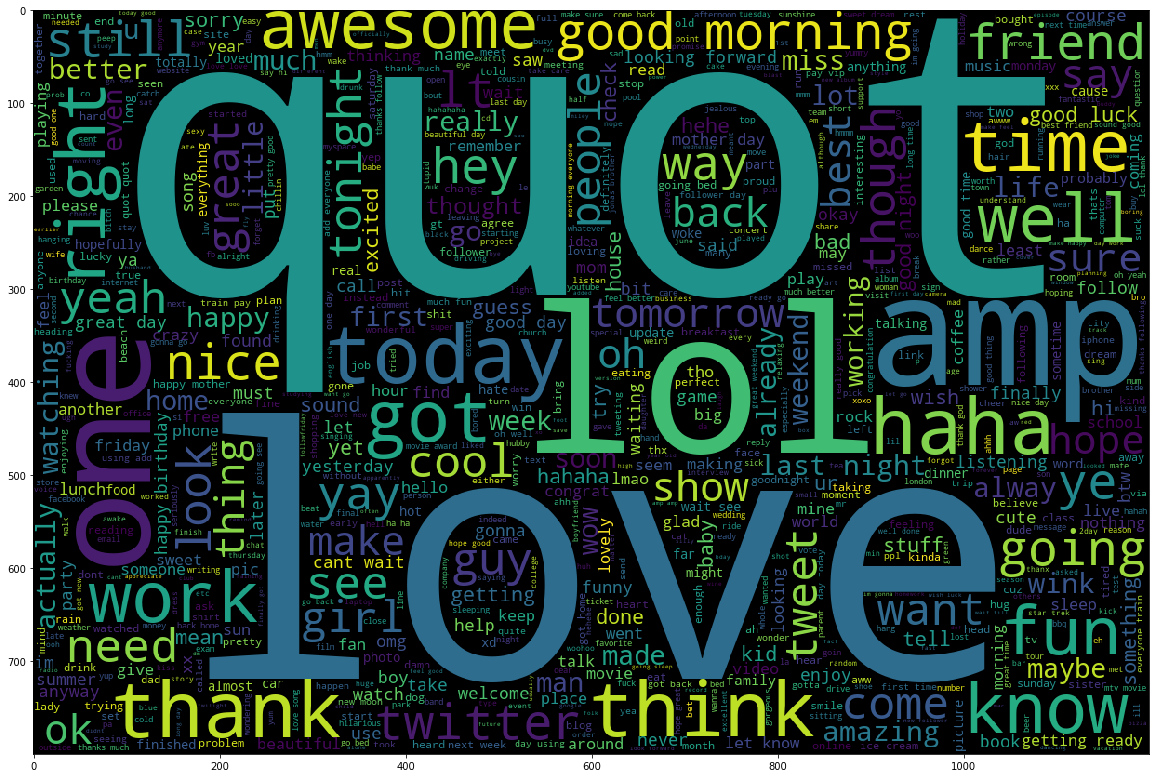

In [65]:
positive_tweets = clean_data[800000:]
plt.figure(figsize = (20,20))
wordCloud = WordCloud(max_words = 800 , width = 1200 , height = 800).generate(" ".join(positive_tweets))
plt.imshow(wordCloud)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_data, labels,
                                                    test_size = 0.1, random_state = 0)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=200000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=200000, ngram_range=(1, 2))

In [22]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [23]:
print(X_train.shape)
print(X_test.shape)

(1440000, 200000)
(160000, 200000)


### Logistic Regression

In [ ]:
#This cell does the grid search the find put the best hyperparameters for logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
param_grid = { 
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['liblinear'],
    'max_iter' : [2000],
    'n_jobs' : [-1]}

clf=GridSearchCV(model,param_grid, cv=5, verbose=True)
clf.fit(X_train,y_train)
logreg_best_params = clf.best_params_
print(logreg_best_params)
print(clf.best_score_)
#IT WILL TAKE A LOT OF TIME TO RUN THIS CELL

In [27]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(C=0.01,penalty='l1',solver='liblinear', max_iter=2000)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

conf_mat = metrics.confusion_matrix(y_test,y_pred)
error1 = conf_mat[0][1]/(conf_mat[0][0]+conf_mat[0][1])
error2 = 1-metrics.recall_score(y_test, y_pred)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Error type 1:",error1)
print("Error type 2:",error2)
print(conf_mat)

Accuracy: 0.7317
Precision: 0.706037527593819
Recall: 0.7969773990182153
Error type 1: 0.3340063708645815
Error type 2: 0.2030226009817847
[[53105 26633]
 [16295 63967]]


Text(0.5, 257.44, 'Predicted label')

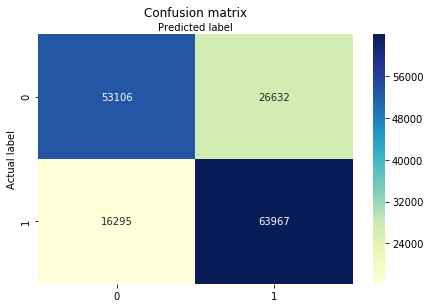

In [25]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

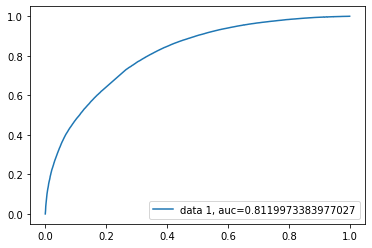

In [26]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### SVC

In [25]:
from sklearn import svm

C = [0.1, 1, 10, 100]
gamma = [0.001, 0.01, 0.1, 1]
kernel = ['rbf' , 'linear', 'poly']
param_grid = {'C': C, 'gamma' : gamma , 'kernel' : kernel}

In [ ]:
#This cell does the grid search the find put the best hyperparameters for SVC
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

svc_best_params = grid_search.best_params_

In [28]:
svc_best = svm.SVC(max_iter = 3000)


svc_best.fit(X_train, y_train)
y_pred = svc_best.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test,y_pred)
error1 = conf_mat[0][1]/(conf_mat[0][0]+conf_mat[0][1])
error2 = 1-metrics.recall_score(y_test, y_pred)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Error type 1:",error1)
print("Error type 2:",error2)
print(conf_mat)

F:\anaconda\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.50079375
Precision: 0.6313301823092505
Recall: 0.011649348384042262
Error type 1: 0.006847425317916176
Error type 2: 0.9883506516159577
[[79192   546]
 [79327   935]]


Text(0.5, 257.44, 'Predicted label')

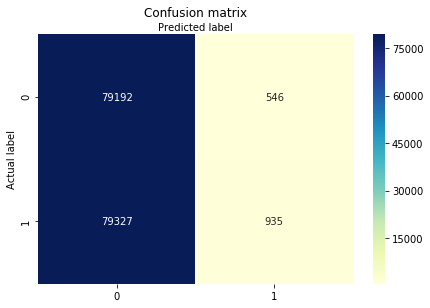

In [29]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
from sklearn.naive_bayes import MultinomialNB

multiNB = MultinomialNB()


multiNB.fit(X_train, y_train)
y_pred = multiNB.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test,y_pred)
error1 = conf_mat[0][1]/(conf_mat[0][0]+conf_mat[0][1])
error2 = 1-metrics.recall_score(y_test, y_pred)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Error type 1:",error1)
print("Error type 2:",error2)
print(conf_mat)

Accuracy: 0.777525
Precision: 0.7783067068763552
Recall: 0.7781515536617577
Error type 1: 0.2231056710727633
Error type 2: 0.2218484463382423
[[61948 17790]
 [17806 62456]]


Text(0.5, 257.44, 'Predicted label')

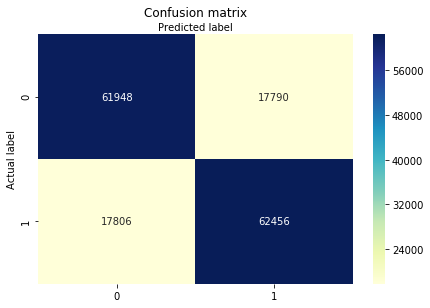

In [32]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

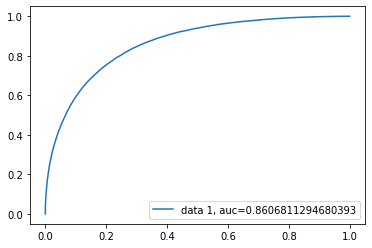

In [33]:
y_pred_proba = multiNB.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [38]:
from sklearn.naive_bayes import BernoulliNB

bernouliNB = BernoulliNB()


bernouliNB.fit(X_train, y_train)
y_pred = bernouliNB.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test,y_pred)
error1 = conf_mat[0][1]/(conf_mat[0][0]+conf_mat[0][1])
error2 = 1-metrics.recall_score(y_test, y_pred)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Error type 1:",error1)
print("Error type 2:",error2)
print(conf_mat)

Accuracy: 0.77910625
Precision: 0.7677287844651861
Recall: 0.8024220677281901
Error type 1: 0.24436278813112944
Error type 2: 0.19757793227180986
[[60253 19485]
 [15858 64404]]


Text(0.5, 257.44, 'Predicted label')

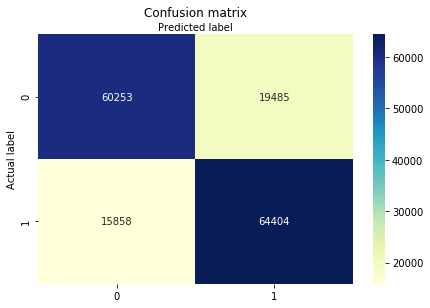

In [39]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

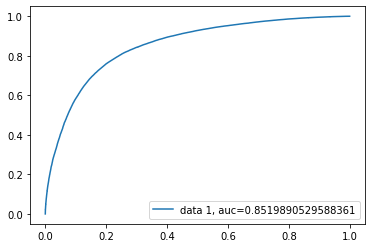

In [40]:
y_pred_proba = bernouliNB.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [42]:
import xgboost

model = xgboost.XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test,y_pred)
error1 = conf_mat[0][1]/(conf_mat[0][0]+conf_mat[0][1])
error2 = 1-metrics.recall_score(y_test, y_pred)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Error type 1:",error1)
print("Error type 2:",error2)
print(conf_mat)

Accuracy: 0.67200625
Precision: 0.6215194856318068
Recall: 0.8852134260297526
Error type 1: 0.5426020216208082
Error type 2: 0.11478657397024739
[[36472 43266]
 [ 9213 71049]]


Text(0.5, 257.44, 'Predicted label')

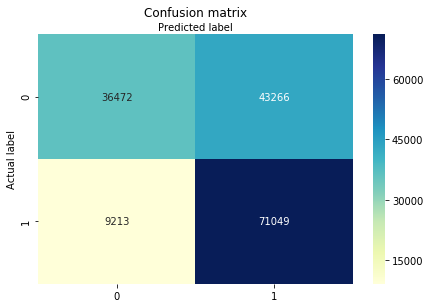

In [43]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

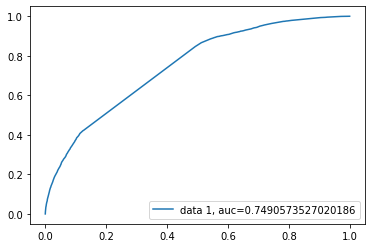

In [44]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()